# Plot CUSP & Census Tracts
### Import Modules

In [1]:
import os
import shapely
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
from geopandas.tools import sjoin
import matplotlib.pyplot as pl
from fiona.crs import from_epsg
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Define Functions

In [2]:
def curlfile(url, outfile):
    """Downloads file from url to PUIdata, returns output file path.
    Arguments:
    url - url location of descired file (string).
    outfile - name of downloaded file (string).
    """
    outfile = os.getenv('PUIDATA') + outfile
    os.system('curl -o ' + outfile + ' ' + url)
    return outfile


def unzipPUIDATA(infile, outfolder):
    """Unzips file on PUIDATA, returns folder path.
    Arguments:
    infile - filename in PUIDATA
    outfolder - name of unzipped folder
    """
    infile = os.getenv('PUIDATA') + '/' + infile
    outfolder = os.getenv('PUIDATA') + outfolder + '/'
    os.system('unzip ' + infile + ' -d ' + outfolder)
    return outfolder

### Download, Load Census Tract, Extract BK, & Reproject to WGS 84.

In [3]:
path = 'http://www1.nyc.gov/assets/planning/download/zip/'\
       'data-maps/open-data/nyct2010_16d.zip'
ctzip = curlfile(path, 'nyct2010_16d.zip')
unzipPUIDATA('nyct2010_16d.zip', '')

'/Users/JordanVani/Documents/NYU/PUI/PUIdata//'

In [4]:
ctpath = os.getenv('PUIDATA') + 'nyct2010_16d/nyct2010.shp'
ct_shape = gp.GeoDataFrame.from_file(ctpath)
ct_bk = ct_shape[ct_shape.BoroName == 'Brooklyn']
ct_bk = ct_bk.to_crs(epsg=4326)

### Create point of CUSP geometry.

In [5]:
CUSP = [['CUSP', 40.693217, -73.986403]]
CUSP = pd.DataFrame(CUSP, columns=['Name', 'Lat', 'Long'])
CUSP['LongLat'] = zip(CUSP.Long, CUSP.Lat)
CUSP['geometry'] = CUSP[['LongLat']].applymap(
    lambda x: shapely.geometry.Point(x))
CUSP = gp.GeoDataFrame(CUSP, geometry='geometry')
CUSP.crs = {'init': 'epsg:4326'}

### Find the census tract CUSP is in.

In [6]:
ct_bk[ct_bk.geometry.intersects(CUSP.iloc[0].geometry)].BoroCT2010.values[0]

u'3001100'

### Plot CT with CUSP.

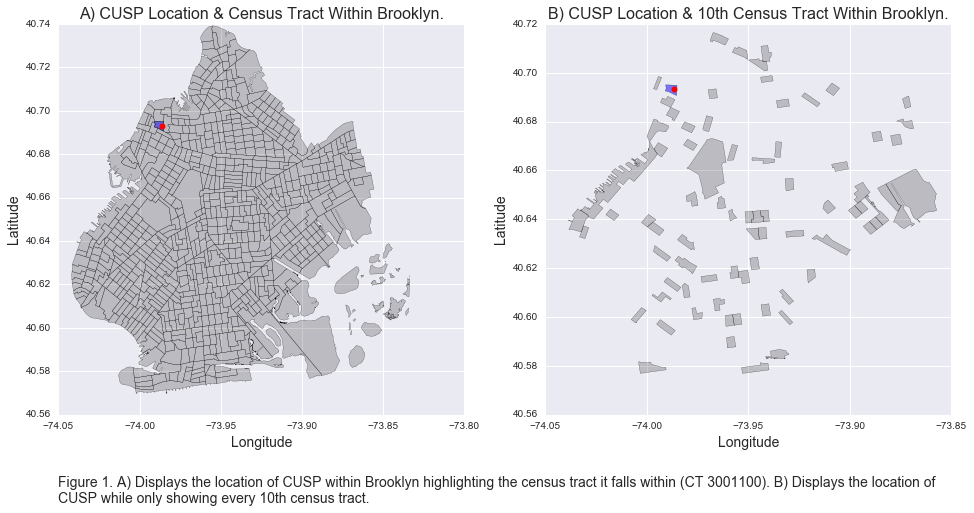

In [7]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 7))

ct_bk.plot(ax=ax1, color='k', alpha=0.2, linewidth=0.2)
ct_bk.loc[ct_bk['BoroCT2010'] == '3001100'].plot(
    ax=ax1, color='b', linewidth=0.2)
CUSP.plot(ax=ax1, color='r', markersize='6')
ax1.set_xlabel('Longitude', fontsize=14)
ax1.set_ylabel('Latitude', fontsize=14)
ax1.set_title('A) CUSP Location & Census Tract Within Brooklyn.', fontsize=16)

ct_bk.iloc[::10].plot(ax=ax2, color='k', alpha=0.2, linewidth=0.2)
ct_bk.loc[ct_bk['BoroCT2010'] == '3001100'].plot(
    ax=ax2, color='b', linewidth=0.2)
CUSP.plot(ax=ax2, color='r', markersize='6')
ax2.set_xlabel('Longitude', fontsize=14)
ax2.set_ylabel('Latitude', fontsize=14)
ax2.set_title('B) CUSP Location & 10th Census Tract Within Brooklyn.',
              fontsize=16)

fig.text(0.125, -0.05, 'Figure 1. A) Displays the location of CUSP '
         'within Brooklyn highlighting the census tract it falls within '
         '(CT 3001100). B) Displays the location of \nCUSP while only '
         'showing every 10th census tract.', fontsize=14)